In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import MobileNetV2
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.utils import image_dataset_from_directory

from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

2025-08-25 13:42:19.974235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756129340.192889      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756129340.250858      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
test_dir = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"

# Load training dataset
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    seed=42,
    subset="training"
)

validation_ds = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    seed=42,
    subset="validation"
)



# Normalization layer: divides pixel values by 255
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to datasets
train = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation = validation_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


I0000 00:00:1756129391.805428      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [3]:
conv_base = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [5]:
conv_base.trainable = True
for layer in conv_base.layers[:-30]:  # Freeze all but last 30 layers
    layer.trainable = False

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
], name="data_augmentation")

model = Sequential()
model.add(data_augmentation)
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(len(train_ds.class_names), activation = "softmax", dtype = "float32"))

model.compile(optimizer=RMSprop(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,526,400 (5.82 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [7]:
history = model.fit(train, epochs = 5, validation_data = validation)

Epoch 1/5


I0000 00:00:1756129462.815417     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 254s 109ms/step - accuracy: 0.3845 - loss: 2.3159 - val_accuracy: 0.9441 - val_loss: 0.2487
Epoch 2/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 225s 104ms/step - accuracy: 0.9073 - loss: 0.3564 - val_accuracy: 0.9809 - val_loss: 0.0879
Epoch 3/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 223s 103ms/step - accuracy: 0.9543 - loss: 0.1616 - val_accuracy: 0.9895 - val_loss: 0.0482
Epoch 4/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 223s 103ms/step - accuracy: 0.9751 - loss: 0.0918 - val_accuracy: 0.9924 - val_loss: 0.0319
Epoch 5/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 224s 103ms/step - accuracy: 0.9828 - loss: 0.0650 - val_accuracy: 0.9945 - val_loss: 0.0223


In [13]:
loss, accuracy = model.evaluate(validation)
print(f"validation Loss : ", loss)
print(f"Validation Accuracy : ", accuracy)

544/544 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9944 - loss: 0.0229
validation Loss :  0.022273020818829536
Validation Accuracy :  0.9945402145385742


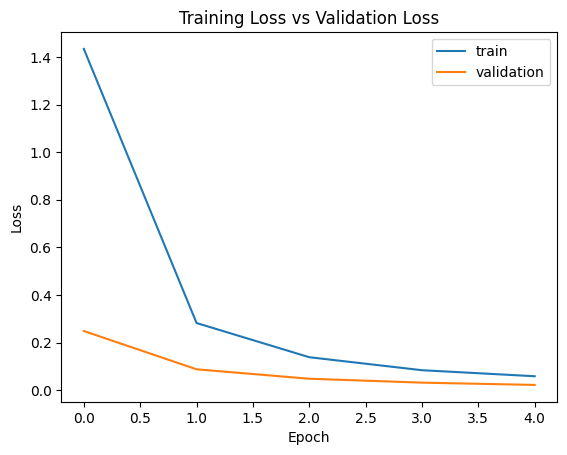

In [14]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "validation")
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

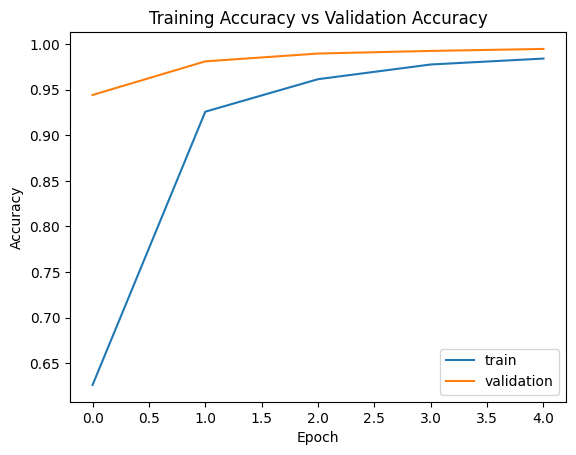

In [15]:
plt.plot(history.history["accuracy"], label = "train")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [8]:
# Save the Model
model.save("model.keras")

In [10]:
import json
with open("asl_labels.json", "w") as f:
    json.dump(dict(enumerate(train_ds.class_names)), f)